In [1]:
import os
import sys

import logging
import re
import pathlib

import datetime

import numpy as np
import pandas as pd
from scipy.stats import pearsonr

import matplotlib.pyplot as plt

from pyplink import PyPlink

from basic_tools import *

# load plink, aa and check integrity

In [2]:
plink_KCHIP_HLA_AA_SNP_1000G=PyPlink(plink_KCHIP_HLA_AA_SNP_1000G_path)
plink_KCHIP_HLA_AA_SNP_1000G_fam=plink_KCHIP_HLA_AA_SNP_1000G.get_fam().astype({'fid':str,'iid':str}).rename(columns={'fid':'FID','iid':'IID'})
plink_KCHIP_HLA_AA_SNP_1000G_bim=plink_KCHIP_HLA_AA_SNP_1000G.get_bim()

# load phenotype and check integrity

In [3]:
phenotypes=pd.read_csv(pheno_all_file_path,sep='\t')

In [4]:
phenotypes=phenotypes.set_index('ID').loc[plink_KCHIP_HLA_AA_SNP_1000G_fam['IID']]
phenotypes.shape

(125673, 101)

In [5]:
def cal_maf(dosage_array):
    maf=((dosage_array==1).sum()+2*(dosage_array==2).sum())/\
         (2*(dosage_array!=-1).sum())
    return maf

maf_list_list=[]
for idx_bim,(SNP,row) in enumerate(plink_KCHIP_HLA_AA_SNP_1000G_bim.iterrows()):
    maf_list=[]
    dosage=plink_KCHIP_HLA_AA_SNP_1000G.get_geno_marker(SNP)
    maf_list.append(cal_maf(dosage))
    for cohort in range(1,3+1):
        cohort_dosage=dosage[phenotypes['cohort']==cohort]
        #print('total: {:5d} -1:{:5d} 0:{:5d} 1:{:5d} 2:{:5d}'.format(len(cohort_dosage),(cohort_dosage==-1).sum(),(cohort_dosage==0).sum(),(cohort_dosage==1).sum(),(cohort_dosage==2).sum()))
        maf_list.append(cal_maf(cohort_dosage))
    maf_list_list.append(maf_list)

/home/ch6845/tools/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in long_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
assert (phenotypes.index!=plink_KCHIP_HLA_AA_SNP_1000G_fam['IID']).sum()==0

In [84]:
maf_df=pd.DataFrame(maf_list_list,index=plink_KCHIP_HLA_AA_SNP_1000G_bim.index,columns=['all','AS','CT','NC'])
maf_df['pos_MB']=plink_KCHIP_HLA_AA_SNP_1000G_bim['pos']/1000000
maf_df['pos']=plink_KCHIP_HLA_AA_SNP_1000G_bim['pos']
maf_df['A1']=plink_KCHIP_HLA_AA_SNP_1000G_bim['a1']
maf_df['A2']=plink_KCHIP_HLA_AA_SNP_1000G_bim['a2']

In [87]:
maf_df[['pos','A1','A2','all','AS','CT','NC']].to_csv("maf.tsv",sep='\t')

In [72]:
#maf_df=maf_df[maf_df.isnull().sum(axis=1)==0]

maf_df['all_minor']=np.where(maf_df['all']>0.5,1-maf_df['all'],maf_df['all'])
maf_df['AS_minor']=np.where(maf_df['all']>0.5,1-maf_df['AS'],maf_df['AS'])
maf_df['CT_minor']=np.where(maf_df['all']>0.5,1-maf_df['CT'],maf_df['CT'])
maf_df['NC_minor']=np.where(maf_df['all']>0.5,1-maf_df['NC'],maf_df['NC'])

In [73]:
maf_df['all_weighted_minor']=(maf_df['AS_minor']+maf_df['CT_minor']+maf_df['NC_minor'])/3#(maf_df['AS']*(phenotypes['cohort']==1).sum()+maf_df['CT']*(phenotypes['cohort']==2).sum()+maf_df['NC']*(phenotypes['cohort']==3).sum())/(phenotypes['cohort'].shape[0])

In [74]:
#maf_df['AS_diff_minor']=(maf_df['AS_minor']-maf_df['all_minor'])#.abs()
#maf_df['CT_diff_minor']=(maf_df['CT_minor']-maf_df['all_minor'])#.abs()
#maf_df['NC_diff_minor']=(maf_df['NC_minor']-maf_df['all_minor'])#.abs()


maf_df['AS_diff_weighted_minor']=(maf_df['AS_minor']-maf_df['all_weighted_minor']).abs()
maf_df['CT_diff_weighted_minor']=(maf_df['CT_minor']-maf_df['all_weighted_minor']).abs()
maf_df['NC_diff_weighted_minor']=(maf_df['NC_minor']-maf_df['all_weighted_minor']).abs()



In [75]:
maf_df.head()

,all,AS,CT,NC,pos_MB,all_minor,AS_minor,CT_minor,NC_minor,all_weighted_minor,AS_diff_weighted_minor,CT_diff_weighted_minor,NC_diff_weighted_minor
snp,,,,,,,,,,,,,
6:28000361_T/C,0.094969,0.093335,0.094550,0.097821,28.000361,0.094969,0.093335,0.094550,0.097821,0.095235,0.001900,0.000685,0.002586
6:28000610_C/A,0.094949,0.093269,0.094530,0.097821,28.000610,0.094949,0.093269,0.094530,0.097821,0.095207,0.001937,0.000677,0.002614
6:28001003_A/C,0.088858,0.086368,0.088550,0.091474,28.001003,0.088858,0.086368,0.088550,0.091474,0.088797,0.002429,0.000247,0.002677
6:28001033_T/C,0.309947,0.309780,0.309543,0.312133,28.001033,0.309947,0.309780,0.309543,0.312133,0.310486,0.000705,0.000942,0.001647
6:28001610_T/C,0.309939,0.309780,0.309533,0.312133,28.001610,0.309939,0.309780,0.309533,0.312133,0.310482,0.000702,0.000949,0.001651


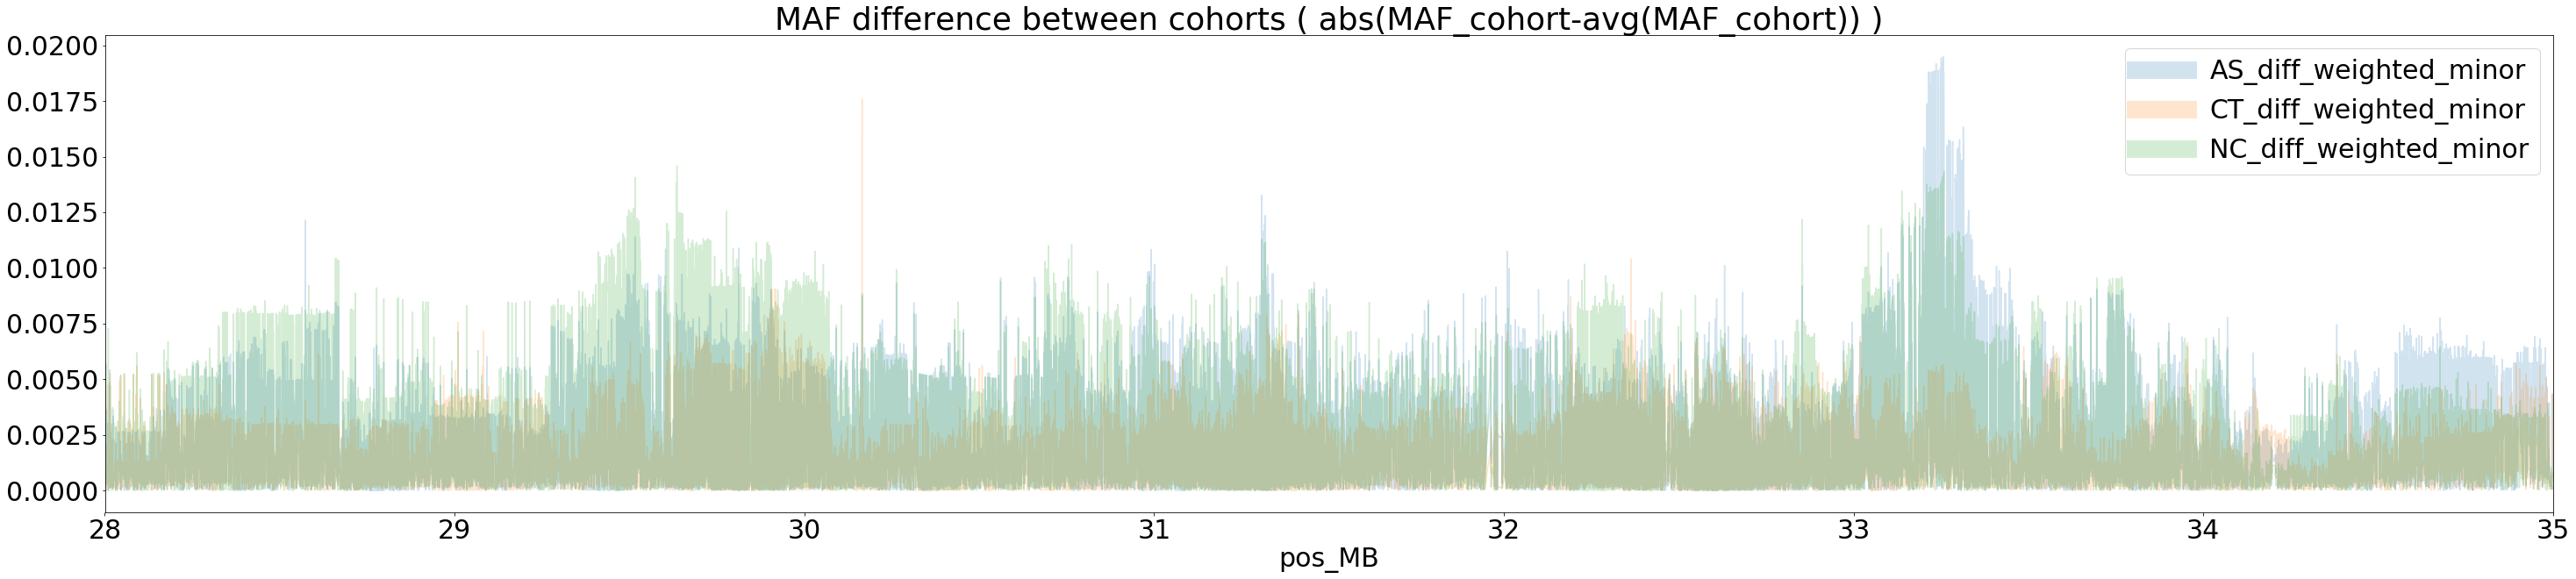

In [80]:
plt.rcParams["figure.figsize"] = (50,10)
plt.rcParams["font.size"]=30

ax=maf_df.set_index('pos_MB')[['AS_diff_weighted_minor','CT_diff_weighted_minor','NC_diff_weighted_minor']].plot(alpha=0.2)

leg = ax.legend()

for line in leg.get_lines():
    line.set_linewidth(20)

plt.title("MAF difference between cohorts ( abs(MAF_cohort-avg(MAF_cohort)) )")
plt.savefig('MAF.svg')

In [169]:
maf_df['AS'].mean(),maf_df['AS'].min(),maf_df['AS'].max()

(0.19483053254227672, 0.004732483239121861, 0.5)

In [170]:
maf_df['CT'].mean(),maf_df['CT'].min(),maf_df['CT'].max()

(0.1946544550292758, 0.004921388880484878, 0.4999848727800805)

In [171]:
maf_df['NC'].mean(),maf_df['NC'].min(),maf_df['NC'].max()

(0.19395682067393166, 0.005103929761464008, 0.5)

In [172]:
maf_df['AS_diff_weighted'].mean(),maf_df['AS_diff_weighted'].min(),maf_df['AS_diff_weighted'].max()

(0.0022412417310651704, 4.579547852046062e-10, 0.019479151573028652)

In [173]:
maf_df['CT_diff_weighted'].mean(),maf_df['CT_diff_weighted'].min(),maf_df['CT_diff_weighted'].max()

(0.001673300881159929, 1.2356453422956992e-07, 0.018359628370642617)

In [174]:
maf_df['NC_diff_weighted'].mean(),maf_df['NC_diff_weighted'].min(),maf_df['NC_diff_weighted'].max()

(0.002263989566338635, 6.980417109961334e-08, 0.01458894060723423)

MAF AS>=CT>NC

In [175]:
maf_df.shape

(74904, 11)

In [183]:
(maf_df['AS']<0.05).sum(),(maf_df['AS']<0.01).sum(),(maf_df['AS']<0.005).sum()

(15116, 237, 3)

In [186]:
(maf_df['CT']<0.05).sum(),(maf_df['CT']<0.01).sum(),(maf_df['CT']<0.005).sum()

(15187, 210, 2)

In [187]:
(maf_df['NC']<0.05).sum(),(maf_df['NC']<0.01).sum(),(maf_df['NC']<0.005).sum()

(15357, 160, 0)

In [181]:
(maf_df==0).sum()

all                 0
AS                  0
CT                  0
NC                  0
all_weighted        0
AS_diff             0
CT_diff             0
NC_diff             0
AS_diff_weighted    0
CT_diff_weighted    0
NC_diff_weighted    0
dtype: int64